# Project \#1, Simple Monte Carlo Integration

**Devon DeJohn** | PHY 4611 | February 14, 2019

> This project serves as an introductory foray into the world of numerical integration techniques. This notebook explores the results and limitations of Monte Carlo integration.
>
> The Monte Carlo method does not suffer from the limitations of the Riemann method, namely that integrals that are not Riemann-integrable are perfectly possible, even trivial, using MCI.

### Import and helper functions

Some initialization code necessary for plotting, as well as the helper functions for the various MCI routines used in this notebook.

In [1]:
using Plots
using Random
gr()

# MCI iteration values, in decadal-magnitudinal steps.
nn = [k*10^n for n in 3:9 for k in 1:9];

function mc_unit_circle(n)
    k = sum(1 for _ in 1:n if rand()^2 + rand()^2 < 1)
    return 4*k/n
end
            
function min_thresh(vals, upper, lower)
    last_lower = findlast(x -> x < lower, vals)
    last_upper = findlast(x -> x > upper, vals)
    return max(last_lower, last_upper) + 1
end

function mc_unit_sphere(n)
    k = sum(1 for _ in 1:n if rand()^2 + rand()^2 + rand()^2 < 1)
    return 8*k/n
end

function trunc_ellipsoid(xx,yy,zz,n)
    k = 0
    dx = xx[2] - xx[1]
    dy = yy[2] - yy[1]
    dz = zz[2] - zz[1]
    
    for _ in 1:n
        x = xx[1] + dx*rand()
        y = yy[1] + dy*rand()
        z = zz[1] + dz*rand()
        
        # By definition, these points are already within the truncation boundaries,
        # so we simply need to check if they also lie within the ellipsoid.
        if 2x^2 + 3y^2 + z^2 <= 25
            k += 1
        end
    end
    
    return dx*dy*dz*k/n
end

function rho_ellipsoid(xx,yy,zz,n)
    k = 0
    dx = xx[2] - xx[1]
    dy = yy[2] - yy[1]
    dz = zz[2] - zz[1]
    
    for _ in 1:n
        x = xx[1] + dx*rand()
        y = yy[1] + dy*rand()
        z = zz[1] + dz*rand()
        
        if 2x^2 + 3y^2 + z^2 <= 25
            k += x^2
        end
    end
    
    return dx*dy*dz*k/n
end

function theoretical_error(exp, theo)
    return 100*(exp - theo)/theo
end

function unbiased_error(x1, x2)
    return 200*abs(x1 - x2)/(x1 + x2)
end;

## Approximating $\pi$

> Write a MCI routine to determine the value of $\pi$. How might $\pi$ be found from a simple integration?

From the formula for the area of a circle,

$$A = \pi r^2$$

we can rearrange to solve for $\pi$,

$$\frac{A}{r^2} = \pi$$

And now consider the unit circle, where $r = 1$:

$$A = \pi$$

If we take only the first quadrant, we can write a simple algorithm to determine whether a randomly generated ordered-pair $(x,y)$ lies within the unit circle. Finally, multiplying the result by $4$ we arrive at an approximation for the value of $\pi$.

In [2]:
# Unseeded.
yu = [mc_unit_circle(n) for n in nn]

# Seeded.
Random.seed!(1)
ys = [mc_unit_circle(n) for n in nn];

### Exploring MCI's precision

> Use your language's simple random number generator and note the seed value. Make a graph of the value of $\pi$ as a function of the Log of the random numbers generated. How many random numbers do you need to get $\pi$ accurate to 3 digits `(3.14)`? 5 digits `(3.1416)`?

I was a little disappointed in MCI's ability to converge on the value of $pi$. As shown in the plot below, MCI appears to converge quite quickly after about `10^7` iterations, but if we zoom in a little closer, we can see that while accuracy improves, precision does not seem to be improving.

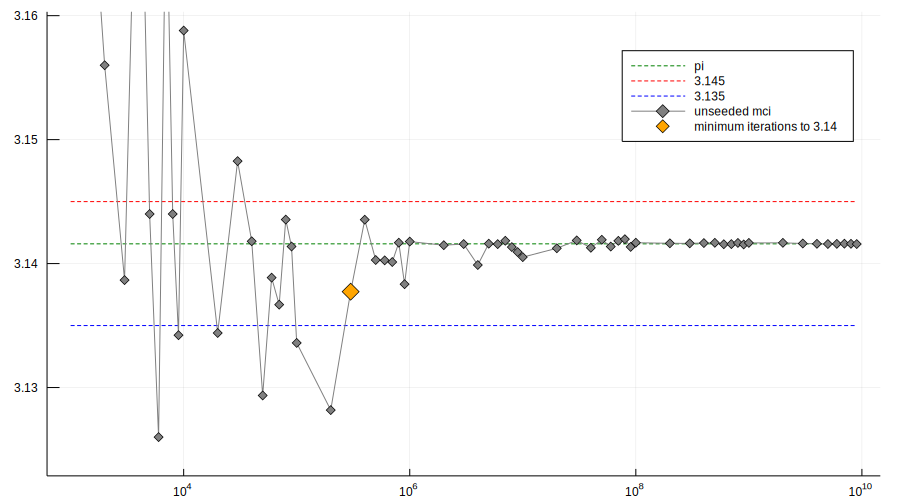

In [3]:
# Base plot x-range.
xx = [minimum(nn), maximum(nn)]

# Upper and lower bounds for values that will round to 3.14.
upper = 3.145
lower = 3.135

# Minimum iterations to stay within threshold.
last_2digits = min_thresh(yu, upper, lower)

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# Pi threshold.
plot!(xx, [upper, upper], l=(1,:dash,:red), label=:"3.145")
plot!(xx, [lower, lower], l=(1,:dash,:blue), label=:"3.135")

# MCI.
plot!(nn, yu, m=(:d, :grey), l=(1,:grey), label=:"unseeded mci")

# Minimum iterations.
scatter!([nn[last_2digits]], [yu[last_2digits]], m=(8, :d, :orange), label=:"minimum iterations to 3.14")

# Center the view on pi.
max_delta = max(pi - 1.001*maximum(yu), pi - 0.999*minimum(yu))
yaxis!((pi - max_delta, pi + max_delta))

### A closer look

The next plot shows a zoomed-in view of the unseeded MCI routine, starting at the minimum iterations to stay within the `3.14` threshold which  took `10^5` data points, and is marked as a red diamond. The orange diamond represents the minimum iterations to `3.1416`, which took `3*10^9` data points. It took four orders of magnitude to get down to 5 digits of precision—a case of diminishing returns if I've ever seen one!

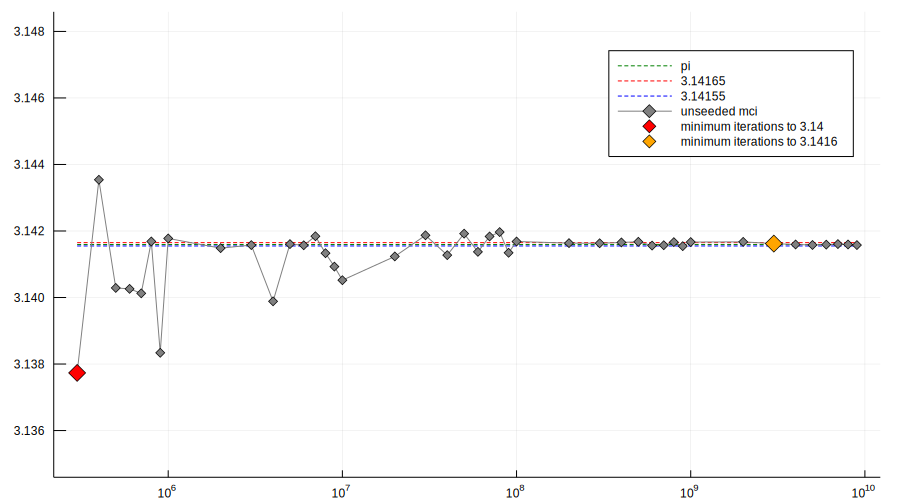

In [4]:
# Base plot x-range.
xx = [minimum(nn[last_2digits:end]), maximum(nn)]

# Upper and lower bounds for values that will round to 3.1416.
upper = 3.14165
lower = 3.14155

# Minimum iterations to stay within threshold.
last_3digits = min_thresh(yu, upper, lower)

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# Pi threshold.
plot!(xx, [upper, upper], l=(1,:dash,:red), label=:"3.14165")
plot!(xx, [lower, lower], l=(1,:dash,:blue), label=:"3.14155")

# MCI.
plot!(nn[last_2digits:end], yu[last_2digits:end], m=(:d, :grey), l=(1,:grey), label=:"unseeded mci")

# Minimum iterations.
scatter!([nn[last_2digits]], [yu[last_2digits]], m=(8, :d, :red), label=:"minimum iterations to 3.14")
scatter!([nn[last_3digits]], [yu[last_3digits]], m=(8, :d, :orange), label=:"minimum iterations to 3.1416")

# Center the view on pi.
max_delta = max(pi - 1.001*maximum(yu[last_2digits:end]), pi - 0.999*minimum(yu[last_2digits:end]))
yaxis!((pi - max_delta, pi + max_delta))

### Using the Mersenne Twister

This MCI routine runs on a seeded Mersenne Twister sequence. The minimum iterations to `3.14` are nearly an order of magnitude *greater* than the unseeded sequence. To account for blind luck, I actually re-ran another unseeded sequence and it still ended up converging to `3.14` more quickly than *this particular Mersenne Twister sequence*. Curious, but I decided not to look into it further.

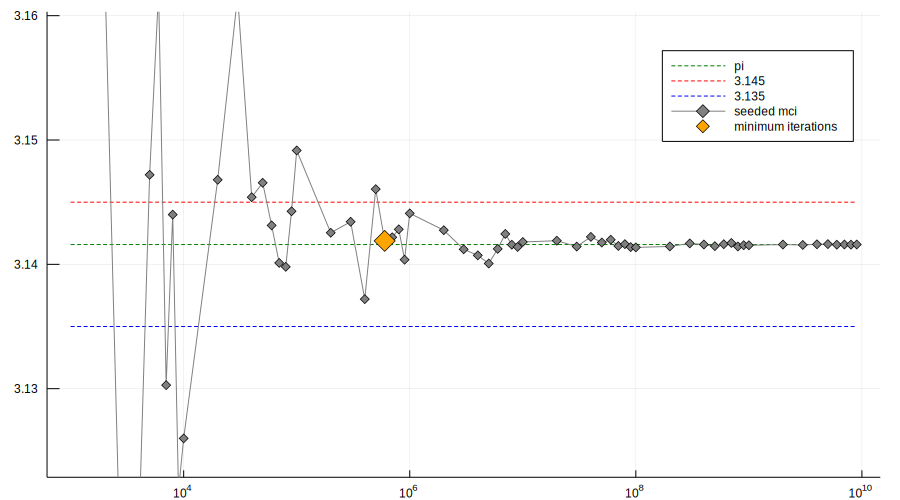

In [5]:
# Base plot x-range.
xx = [minimum(nn), maximum(nn)]

# Upper and lower bounds for values that will round to 3.14.
upper = 3.145
lower = 3.135

# Minimum iterations to stay within threshold.
last_s = min_thresh(ys, upper, lower)

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# Pi threshold.
plot!(xx, [upper, upper], l=(1,:dash,:red), label=:"3.145")
plot!(xx, [lower, lower], l=(1,:dash,:blue), label=:"3.135")

# MCI
plot!(nn, ys, m=(:d, :grey), l=(1,:grey), label=:"seeded mci")

# Minimum iterations.
scatter!([nn[last_s]], [ys[last_s]], m=(10, :d, :orange), label=:"minimum iterations")

# Center the view on pi.
max_delta = max(pi - 1.001*maximum(yu), pi - 0.999*minimum(yu))
yaxis!((pi - max_delta, pi + max_delta))

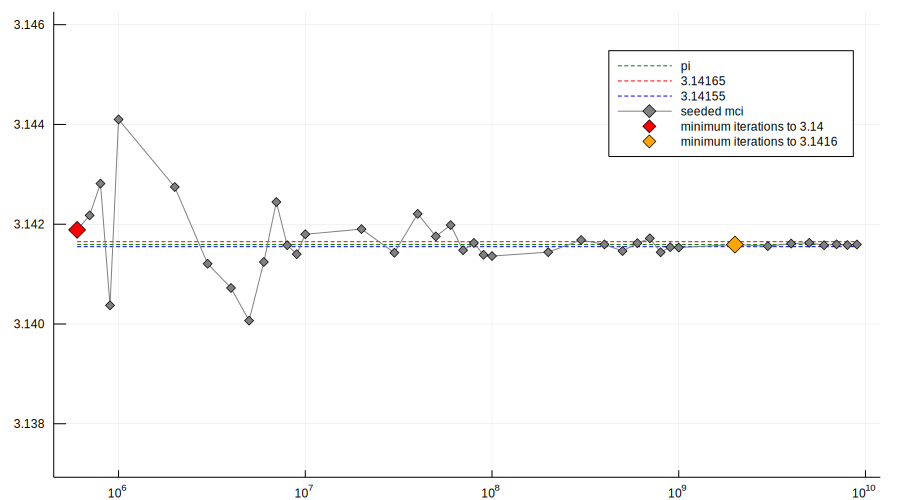

In [6]:
# Base plot x-range.
xx = [minimum(nn[last_s:end]), maximum(nn)]

# Upper and lower bounds for values that will round to 3.1416.
upper = 3.14165
lower = 3.14155

# Minimum iterations to stay within threshold.
last_3digits = min_thresh(ys, upper, lower)

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# Pi threshold.
plot!(xx, [upper, upper], l=(1,:dash,:red), label=:"3.14165")
plot!(xx, [lower, lower], l=(1,:dash,:blue), label=:"3.14155")

# MCI.
plot!(nn[last_s:end], ys[last_s:end], m=(:d, :grey), l=(1,:grey), label=:"seeded mci")

# Minimum iterations.
scatter!([nn[last_s]], [ys[last_s]], m=(8, :d, :red), label=:"minimum iterations to 3.14")
scatter!([nn[last_3digits]], [ys[last_3digits]], m=(8, :d, :orange), label=:"minimum iterations to 3.1416")

# Center the view on pi.
max_delta = max(pi - 1.001*maximum(ys[last_s:end]), pi - 0.999*minimum(ys[last_s:end]))
yaxis!((pi - max_delta, pi + max_delta))

### Unseeded and seeded compared

A comparison between unseeded and seeded is pointless without a visual! The first plot shows the whole range of iterations, `[10^3 .. 9*10^9]`. The second plot compares the two MCIs from `[10^8 .. 9*10^9]`. I think running these two MCIs on `10^12` or more points may reveal some clues about which sequence is indeed the better quality of the two, but `9*10^9` took 30 minutes; this assigment will be due before that integration finishes...

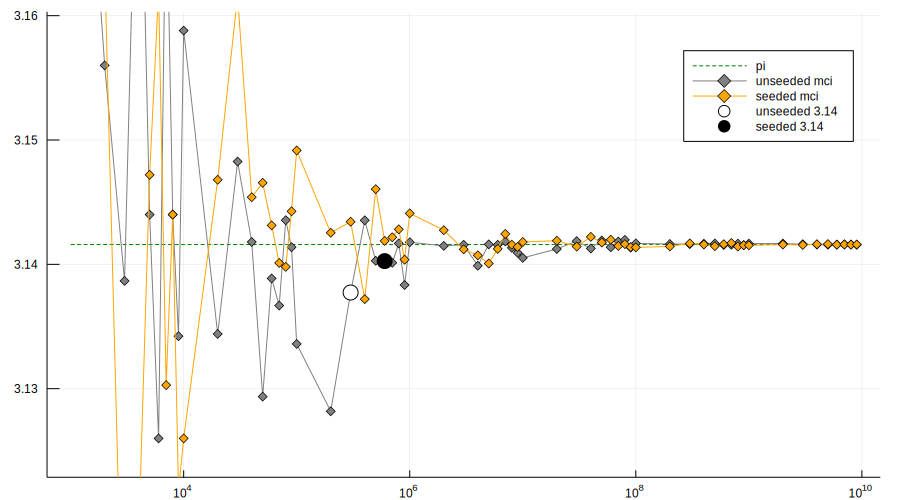

In [7]:
# Base plot x-range.
xx = [minimum(nn), maximum(nn)]

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# MCIs.
plot!(nn, yu, m=(:d, :grey), l=(1,:grey), label=:"unseeded mci")
plot!(nn, ys, m=(:d, :orange), l=(1,:orange), label=:"seeded mci")

# Minimum iterations.
scatter!([nn[last_2digits]], [yu[last_2digits]], m=(8, :white), label=:"unseeded 3.14")
scatter!([nn[last_s]], [yu[last_s]], m=(8, :black), label=:"seeded 3.14")

# Center the view on pi.
max_delta = max(pi - 1.001*maximum(yu), pi - 0.999*minimum(yu))
yaxis!((pi - max_delta, pi + max_delta))

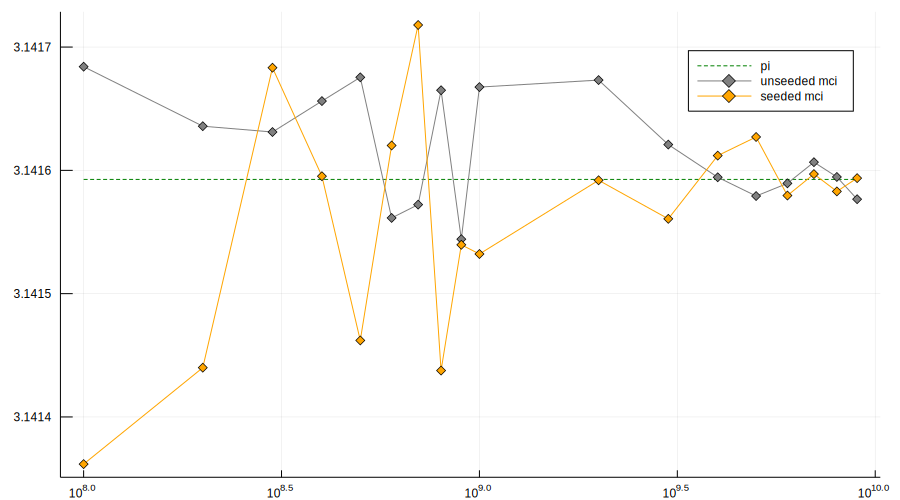

In [8]:
# Base plot x-range.
xx = [10^8, 9*10^9]

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# MCIs.
plot!(nn[(end-17):end], yu[(end-17):end], m=(:d, :grey), l=(1,:grey), label=:"unseeded mci")
plot!(nn[(end-17):end], ys[(end-17):end], m=(:d, :orange), l=(1,:orange), label=:"seeded mci")

## Ellipsoid mass

> Write an MCI routine using your better random generator algorithm to find the mass of an ellipsoid given by: 
>
> $$2x^2 + 3y^2 + z^2 = 25 \;, \text{ with } \rho = 1.000 \; \frac{kg}{m^3}$$
>
> What is the analytic solution? How close can you get with a reasonable number of random points? Compare a reasonable run to the analytic solution and give the percentage error.

This exercise turned out to be pretty demoralizing. I spent more than 12 hours attempting to analytically solve this triple integral in cartesian coordinates. I kept ending up with

$$V = \frac{4}{3}\pi a b^2 c$$

Which is in error by a factor $b$. I worked with two different professors, others in class (including one who has previously passed the class), consulted the *CRC* and *Abramowitz & Stegun*, several online resources, and two different multivariate calculus textbooks, and I could never arrive at the proper formula so I gave up.

For the whole ellipsoid I used the canonical formula

$$V = \frac{4}{3}\pi a b c$$

Which I had known previously, but also was able to find by hand using the Jacobian determinant:

$$\int_{S}^{} dV = \int_{S}^{} \text{det} |J| \; dV$$


Where $x = au, \; y = bv, \; z = cw\;$ and


$$
\text{det}|J| = \text{det}\begin{vmatrix}
    \frac{\partial x}{\partial u} & \frac{\partial x}{\partial v} & \frac{\partial x}{\partial w} \\
    \frac{\partial y}{\partial u} & \frac{\partial y}{\partial v} & \frac{\partial y}{\partial w} \\
    \frac{\partial z}{\partial u} & \frac{\partial z}{\partial v} & \frac{\partial z}{\partial w} \\
\end{vmatrix} = \text{det}\begin{vmatrix}
    \frac{\partial x}{\partial u} & 0 & 0 \\
    0 & \frac{\partial y}{\partial v} & 0 \\
    0 & 0 & \frac{\partial z}{\partial w} \\
\end{vmatrix} = \text{det}\begin{vmatrix}
    a & 0 & 0 \\
    0 & b & 0 \\
    0 & 0 & c \\
\end{vmatrix} = abc
$$


Since the density $\rho$ is $1.000\frac{kg}{m^3}$, the mass of the ellipsoid is simply its volume, which is printed below. I ran this simulation for about thirty minutes, using `10^11` (one-hundred billion) generated `(x, y, z)` points.

I will turn in my workings which are handwritten, rather than clutter up this notebook with a page of LaTeX for an equation with an incorrect result.

## Implementation details

This code is an extension into the third dimension of the unit circle MCI routine I used to approximate the value of $\pi$ earlier. It simply returns the volume of the first octant of the unit sphere:

```julia
function mc_unit_sphere(n)
    k = sum(1 for _ in 1:n if rand()^2 + rand()^2 + rand()^2 < 1)
    return 8*k/n
end
```

In using MCI to find the volume of the whole ellipsoid, the algorithm naturally reduces back down to $abc \cdot \int_{S}^{} dV$ where $\int_{S}^{} dV$ is conventional shorthand to denote the volume of the unit sphere.

Starting first at the random point generation:

1. `x = x_lower_bound + dx * random_point`
2. `y = y_lower_bound + dy * random_point`
3. `z = z_lower_bound + dz * random_point`

Where `random_point` is a float between `0` and `1`; the lower bounds are all `0` when integrating over the first octant; and the delta terms are the upper bounds minus the lower bounds. But since the lower bound for all is `0`, these are simply the semiaxes of the ellipse: `a, b, c` respectively. So these steps reduce to:

1. `x = a * random_point`
2. `y = b * random_point`
3. `z = c * random_point`

Next, after an `(x,y,z)` point is generated, we must check if it lies within the boundaries of the ellipsoid:

4. `if ` $\frac{x^2}{a^2} + \frac{y^2}{b^2} + \frac{z^2}{c^2} \leq 1$ ` increment counter by 1`

But `x = a * random_point`. So `x^2 = a^2 * random_point^2`, which, when divided by `a^2` in the boundary check, cancels with the `a^2` on top, leaving only `random_point^2`. The same is true for `y` and `z`. Thus, the MCI routine for the whole ellipsoid reduces to the area of the domain, `a * b * c` times the ratio of points inside the unit sphere to outside. 

In [9]:
# Ellipsoid axes.
a = 5/sqrt(2)
b = 5/sqrt(3)
c = 5

# Truncated ellipsoid bounding box.
xb = [-1, a]
yb = [-b, b]
zb = [-2, 2]

# Whole ellipsoid analytic mass and MCI result.
a_vol = 4/3*pi*a*b*c
w_vol = a*b*c*mc_unit_sphere(10^11)
println("Analytic mass: ", a_vol)
println("MCI mass: ", w_vol)
println("Error %: ", theoretical_error(w_vol, a_vol))

Analytic mass: 213.75830502697735
MCI mass: 213.7590999483306
Error %: 0.0003718785818154145


## Truncated ellipsoid mass

> Repeat the calculation above, but for the ellipsoid now truncated by $z = \pm 2$ and $x = -1$. Compare a reasonable run to the analytic solution and give the percentage error.

Due to my difficulties in finding the analytic solution to the ellipsoid using cartesian coordinates, I decided not to waste my time on the truncated triple integral. I instead used Wolfram Mathematica to numerically solve for the remaining two triple integrals (truncated and variable density), using 16 digits of precision in the calculations:
    
```mathematica
a = 5/Sqrt[2]
b = 5/Sqrt[3]
c = 5

NIntegrate[Boole[2x^2+3y^2+z^2<=25],{x,-1,a},{y,-b,b},{z,-2,2},WorkingPrecision -> 16]
    
> 82.84888725086089
    
NIntegrate[x^2*Boole[2x^2+3y^2+z^2<=25],{x,-1,a},{y,-b,b},{z,-2,2},WorkingPrecision -> 16]
    
> 187.3430623682275
```
    
I'm aware of the fact that generally speaking, relying on one numerical method to use as a target for another is bad practice, and I will most likely continue working on the analytic solutions well after this project is due.

In [10]:
# Truncated "analytic mass" and MCI result.
at_vol = 82.84888725086089
t_vol = trunc_ellipsoid(xb,yb,zb,10^11)
println("Analytic truncated mass: ", at_vol)
println("Truncated ellipsoid mass: ", t_vol)
println("Error %: ", theoretical_error(at_vol, t_vol))

Analytic truncated mass: 82.84888725086088
Truncated ellipsoid mass: 82.84881844840562
Error %: 8.304578936517278e-5


## Truncated ellipsoid mass with variable density

> Repeat the calculation above, but for variable density $\rho = x^2 \frac{kg}{m^3}$ and compare this to the analytic solution; give the percentage error.

Adding variable density to the integration requires only that instead of adding `1` each time we find a point inside the truncated ellipsoid, we instead directly add the density of that volume element, which is a function only of its `x`-coordinate.

In [11]:
# Variable density "analytic mass" and MCI result.
ar_vol = 187.3430623682275
r_vol = rho_ellipsoid(xb,yb,zb,10^11)
println("Analytic variable density mass: ", ar_vol)
println("Variable density ellipsoid mass: ", r_vol)
println("Error %: ", theoretical_error(ar_vol, r_vol))

Analytic variable density mass: 187.3430623682275
Variable density ellipsoid mass: 187.34290350219175
Error %: 8.479960157398629e-5


## Explorations

In general, I believe generating random numbers on-the-fly involves less overhead than reading and parsing a file but for a project like this, with a seeded random number sequence and where multiple Monte Carlo integrations are performed, pulling points from a precomputed list would greatly improve performance.

In the case where only a single MCI routine is performed however, then on-the-fly random number generation will be much faster. Unfortunately, I could not test this hypothesis. I tried to precompute `10^9` random `(x,y,z)` points, but I simply don't have the RAM to put it in memory, nor the storage space on this notebook's hosting platform to put it in a text file.

I will continue to try to eke out extra performance where possible throughout the semester, since I am very insterested in improving these MCI routines.

## MCI candidate

> Give an example of a calculation (one not discussed in class) in which the analytic solution would be far too difficult if not impossible to attempt.

The function $f(x) = 2 - e^{x^2}$ is what I immediately though of when reading the problem statement. The antiderivative uses the imaginary error function, and is given by:

$$F(x) = 2x - \frac{1}{2} \sqrt{\pi} \cdot \text{erfi}(x) + C$$

## Closing Remarks

I find basic Monte Carlo Integration quite elegant in its implementation. However I'm slightly disappointed in its results, or rather, *the expense at which reasonable results are obtained.* I am certainly interested in studying more about numerical integration, and I'm particularly curious about Mathematica's implementation, which I believe is a modified MCI routine and is blazingly fast. I'm taking Numerical Analysis I next fall, so I guess I'll have to wait.

## Appendix A, code base

I wrote this notebook in the Julia language, just as a heads up. It is roughly 100x faster than Python running the same code.

```julia
using Plots
using Random
gr()

# MCI iteration values, in decadal-magnitudinal steps.
nn = [k*10^n for n in 3:9 for k in 1:9];

function mc_unit_circle(n)
    k = sum(1 for _ in 1:n if rand()^2 + rand()^2 < 1)
    return 4*k/n
end
            
function min_thresh(vals, upper, lower)
    last_lower = findlast(x -> x < lower, vals)
    last_upper = findlast(x -> x > upper, vals)
    return max(last_lower, last_upper) + 1
end

function mc_unit_sphere(n)
    k = sum(1 for _ in 1:n if rand()^2 + rand()^2 + rand()^2 < 1)
    return 8*k/n
end

function trunc_ellipsoid(xx,yy,zz,n)
    k = 0
    dx = xx[2] - xx[1]
    dy = yy[2] - yy[1]
    dz = zz[2] - zz[1]
    
    for _ in 1:n
        x = xx[1] + dx*rand()
        y = yy[1] + dy*rand()
        z = zz[1] + dz*rand()
        
        # By definition, these points are already within the truncation boundaries,
        # so we simply need to check if they also lie within the ellipsoid.
        if 2x^2 + 3y^2 + z^2 <= 25
            k += 1
        end
    end
    
    return dx*dy*dz*k/n
end

function rho_ellipsoid(xx,yy,zz,n)
    k = 0
    dx = xx[2] - xx[1]
    dy = yy[2] - yy[1]
    dz = zz[2] - zz[1]
    
    for _ in 1:n
        x = xx[1] + dx*rand()
        y = yy[1] + dy*rand()
        z = zz[1] + dz*rand()
        
        if 2x^2 + 3y^2 + z^2 <= 25
            k += x^2
        end
    end
    
    return dx*dy*dz*k/n
end

function theoretical_error(exp, theo)
    return 100*(exp - theo)/theo
end

function unbiased_error(x1, x2)
    return 200*abs(x1 - x2)/(x1 + x2)
end
                                    
# Unseeded.
yu = [mc_unit_circle(n) for n in nn]

# Seeded.
Random.seed!(1)
ys = [mc_unit_circle(n) for n in nn]
                                    
#——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————#
# Plot 1

# Base plot x-range.
xx = [minimum(nn), maximum(nn)]

# Upper and lower bounds for values that will round to 3.14.
upper = 3.145
lower = 3.135

# Minimum iterations to stay within threshold.
last_2digits = min_thresh(yu, upper, lower)

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# Pi threshold.
plot!(xx, [upper, upper], l=(1,:dash,:red), label=:"3.145")
plot!(xx, [lower, lower], l=(1,:dash,:blue), label=:"3.135")

# MCI.
plot!(nn, yu, m=(:d, :grey), l=(1,:grey), label=:"unseeded mci")

# Minimum iterations.
scatter!([nn[last_2digits]], [yu[last_2digits]], m=(8, :d, :orange), label=:"minimum iterations to 3.14")

# Center the view on pi.
max_delta = max(pi - 1.001*maximum(yu), pi - 0.999*minimum(yu))
yaxis!((pi - max_delta, pi + max_delta))

#——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————#
# Plot 2

# Base plot x-range.
xx = [minimum(nn[last_2digits:end]), maximum(nn)]

# Upper and lower bounds for values that will round to 3.1416.
upper = 3.14165
lower = 3.14155

# Minimum iterations to stay within threshold.
last_3digits = min_thresh(yu, upper, lower)

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# Pi threshold.
plot!(xx, [upper, upper], l=(1,:dash,:red), label=:"3.14165")
plot!(xx, [lower, lower], l=(1,:dash,:blue), label=:"3.14155")

# MCI.
plot!(nn[last_2digits:end], yu[last_2digits:end], m=(:d, :grey), l=(1,:grey), label=:"unseeded mci")

# Minimum iterations.
scatter!([nn[last_2digits]], [yu[last_2digits]], m=(8, :d, :red), label=:"minimum iterations to 3.14")
scatter!([nn[last_3digits]], [yu[last_3digits]], m=(8, :d, :orange), label=:"minimum iterations to 3.1416")

# Center the view on pi.
max_delta = max(pi - 1.001*maximum(yu[last_2digits:end]), pi - 0.999*minimum(yu[last_2digits:end]))
yaxis!((pi - max_delta, pi + max_delta))

#——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————#
# Plot 3

# Base plot x-range.
xx = [minimum(nn), maximum(nn)]

# Upper and lower bounds for values that will round to 3.14.
upper = 3.145
lower = 3.135

# Minimum iterations to stay within threshold.
last_s = min_thresh(ys, upper, lower)

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# Pi threshold.
plot!(xx, [upper, upper], l=(1,:dash,:red), label=:"3.145")
plot!(xx, [lower, lower], l=(1,:dash,:blue), label=:"3.135")

# MCI
plot!(nn, ys, m=(:d, :grey), l=(1,:grey), label=:"seeded mci")

# Minimum iterations.
scatter!([nn[last_s]], [ys[last_s]], m=(10, :d, :orange), label=:"minimum iterations")

# Center the view on pi.
max_delta = max(pi - 1.001*maximum(yu), pi - 0.999*minimum(yu))
yaxis!((pi - max_delta, pi + max_delta))

#——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————#
# Plot 4

# Base plot x-range.
xx = [minimum(nn[last_s:end]), maximum(nn)]

# Upper and lower bounds for values that will round to 3.1416.
upper = 3.14165
lower = 3.14155

# Minimum iterations to stay within threshold.
last_3digits = min_thresh(ys, upper, lower)

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# Pi threshold.
plot!(xx, [upper, upper], l=(1,:dash,:red), label=:"3.14165")
plot!(xx, [lower, lower], l=(1,:dash,:blue), label=:"3.14155")

# MCI.
plot!(nn[last_s:end], ys[last_s:end], m=(:d, :grey), l=(1,:grey), label=:"seeded mci")

# Minimum iterations.
scatter!([nn[last_s]], [ys[last_s]], m=(8, :d, :red), label=:"minimum iterations to 3.14")
scatter!([nn[last_3digits]], [ys[last_3digits]], m=(8, :d, :orange), label=:"minimum iterations to 3.1416")

# Center the view on pi.
max_delta = max(pi - 1.001*maximum(ys[last_s:end]), pi - 0.999*minimum(ys[last_s:end]))
yaxis!((pi - max_delta, pi + max_delta))

#——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————#
# Plot 5

# Base plot x-range.
xx = [minimum(nn), maximum(nn)]

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# MCIs.
plot!(nn, yu, m=(:d, :grey), l=(1,:grey), label=:"unseeded mci")
plot!(nn, ys, m=(:d, :orange), l=(1,:orange), label=:"seeded mci")

# Minimum iterations.
scatter!([nn[last_2digits]], [yu[last_2digits]], m=(8, :white), label=:"unseeded 3.14")
scatter!([nn[last_s]], [yu[last_s]], m=(8, :white), label=:"seeded 3.14")

# Center the view on pi.
max_delta = max(pi - 1.001*maximum(yu), pi - 0.999*minimum(yu))
yaxis!((pi - max_delta, pi + max_delta))

#——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————#
# Plot 6

# Base plot x-range.
xx = [10^8, 9*10^9]

# Base plot.
plot(xx, [pi,pi], l=(1,:dash,:green), label=:pi, size=(900,500), xscale=:log10)

# MCIs.
plot!(nn[(end-17):end], yu[(end-17):end], m=(:d, :grey), l=(1,:grey), label=:"unseeded mci")
plot!(nn[(end-17):end], ys[(end-17):end], m=(:d, :orange), l=(1,:orange), label=:"seeded mci")

#——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————#
# Begin ellipsoid calcs

# Not enough RAM for this.
# t = @elapsed iters = [[rand(), rand(), rand()] for _ in 1:10^9]

# Ellipsoid axes.
a = 5/sqrt(2)
b = 5/sqrt(3)
c = 5

# Truncated ellipsoid bounding box.
xb = [-1, a]
yb = [-b, b]
zb = [-2, 2]

# Whole ellipsoid analytic mass and MCI result.
a_vol = 4/3*pi*a*b*c
w_vol = a*b*c*mc_unit_sphere(10^11)
println("Analytic mass: ", a_vol)
println("MCI mass: ", w_vol)
println("Error %: ", theoretical_error(w_vol, a_vol))

# Truncated "analytic mass" and MCI result.
at_vol = 82.84888725086089
t_vol = trunc_ellipsoid(xb,yb,zb,10^11)
println("Analytic truncated mass: ", at_vol)
println("Truncated ellipsoid mass: ", t_vol)
println("Error %: ", theoretical_error(at_vol, t_vol))

# Variable density "analytic mass" and MCI result.
ar_vol = 187.3430623682275
r_vol = rho_ellipsoid(xb,yb,zb,10^11)
println("Analytic variable density mass: ", ar_vol)
println("Variable density ellipsoid mass: ", r_vol)
println("Error %: ", theoretical_error(ar_vol, r_vol))
```